# Analysing unannotated TSSs

In [1]:
import pandas as pd
from collections import defaultdict
import pyranges as pr
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from collections import defaultdict
from matplotlib import font_manager
import numpy as np
import csv
import pickle

/users/jferrer/jmidgley/annotation_project/lib64/python3.9/site-packages/sorted_nearest/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
pd.set_option('display.max_columns', None)

In [3]:
def split_attributes(df, *attribute_type):
    """split attribute of a gtf into separate columns"""
    try: 
        l_attributes = df.strip(';').split('; ')
        attribute_position = [i for i, x in enumerate(l_attributes) if x.startswith(attribute_type)]
        attribute = l_attributes[attribute_position[0]].split(' ')[1].strip('"')
        return attribute
    except Exception:
        return np.nan

In [38]:
font_path = "../data_raw/fonts/LatinmodernmathRegular.otf"  
font_manager.fontManager.addfont(font_path)

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
font = {'family' : 'Latin Modern Math',
       'weight' : 'normal',
       'size'   : 10}

mpl.rc('font', **font)
mpl.rc('lines', lw=1, c='k')

In [5]:
combined_df = pd.read_csv('../data_processed/curated_HIT.tsv', sep='\t')
combined_df.head()

/tmp/19452335/ipykernel_54346/1213649169.py:1: DtypeWarning: Columns (3,5) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_df = pd.read_csv('../data_processed/curated_HIT.tsv', sep='\t')


,transcript_id,chr,exons,matched_to,category,unannotated_exons,Strand,summarized_category,ref_id,stripped_ref_id,Gene stable ID,Gene name,Gene type,gene_category,peak_name,peak_type,mean_TPM_ref,log2_tx_exp,gene_exp_ref,relative_tx_exp,TSS_TPM_per_gene,Relative TSS usage,TSS_type,TSS_start,TSS_end,distance_to_closest_TSS,closest_TSS_ref_id,TSS distance category,TSS_name
0,ENCT00000006334.1,chr1,"[(61077274, 61077628), (61077916, 61079203)]","[(61077326, 61077628), (61077916, 61079231)]",GENCODE-annotated transcripts,NaN,+,GENCODE-annotated transcripts,ENST00000699992.1,ENST00000699992,ENSG00000162599,NFIA,protein_coding,protein_coding,chr1:61077221-61077380_Peak_3111,Permissive,0.178215,-2.488310,4.820350,0.036971,0.213765,0.044346,minor TSS,61077221.0,61077380.0,6.0,ENST00000699964.1,<=100bp,P3111_A
1,ENCT00000013056.1,chr1,"[(160261734, 160261922), (160281430, 160281892)]","[(160261682, 160261922), (160281430, 160281935)]",GENCODE-annotated transcripts,NaN,+,GENCODE-annotated transcripts,ENST00000756371.1,ENST00000756371,ENSG00000228606,DCAF8-DT,lncRNA,lncRNA,chr1:160261726-160261763_Peak_5604,Permissive,0.358414,-1.480300,0.743874,0.481821,0.743874,1.000000,unique TSS,160261726.0,160261763.0,0.0,ENST00000442130.1,<=100bp,P5604_A
2,ENCT00000019620.1,chr1,"[(239386568, 239387227), (239492709, 239492807...","[(239386568, 239387227), (239492709, 239492807...",GENCODE-annotated transcripts,NaN,+,GENCODE-annotated transcripts,ENST00000676153.1,ENST00000676153,ENSG00000133019,CHRM3,protein_coding,protein_coding,chr1:239386576-239386587_Peak_7900,Robust,0.468766,-1.093061,3.127170,0.149901,1.421490,0.454561,main TSS,239386576.0,239386587.0,8.0,ENST00000676153.1,<=100bp,P7900_A
3,ENCT00000022754.1,chr1,"[(23191893, 23195001), (23217291, 23217499)]","[(23191895, 23195001), (23217291, 23217502)]",GENCODE-annotated transcripts,NaN,-,GENCODE-annotated transcripts,ENST00000374619.2,ENST00000374619,ENSG00000179546,HTR1D,protein_coding,protein_coding,chr1:23217498-23217499_Peak_1212,Permissive,0.064644,-3.951339,0.116743,0.553728,0.116743,1.000000,unique TSS,23217498.0,23217499.0,3.0,ENST00000374619.2,<=100bp,P1212_A
4,ENCT00000039204.1,chr1,"[(233319835, 233321155), (233327229, 233327357)]","[(233319834, 233321155), (233327229, 233327455)]",GENCODE-annotated transcripts,NaN,-,GENCODE-annotated transcripts,ENST00000771587.1,ENST00000771587,ENSG00000300424,ENSG00000300424,lncRNA,lncRNA,chr1:233327323-233327461_Peak_7654,Permissive,0.616169,-0.698603,2.291033,0.268948,2.093885,0.913948,main TSS,233327323.0,233327461.0,3.0,ENST00000771586.1,<=100bp,P7654_A


In [7]:
# Load gencode v47 transcripts
gencode_v47_transcripts = pd.read_csv("../data_raw/gencode.v47.transcript.tsv", sep="\t", dtype=str)
gencode_v47_transcripts["start"] = gencode_v47_transcripts["start"].astype(int)
gencode_v47_transcripts["end"] = gencode_v47_transcripts["end"].astype(int)

gencode_v47_transcripts = gencode_v47_transcripts.rename(columns={"seqname": "chr"})

gencode_v47_transcripts.head()

,chr,source,feature,start,end,score,strand,frame,gene_id,transcript_id,gene_type,gene_name,transcript_type,transcript_name,level,tag,transcript_support_level,havana_transcript,hgnc_id,ont,havana_gene,protein_id,ccdsid
0,chr1,HAVANA,transcript,11121,14413,.,+,.,ENSG00000290825.2,ENST00000832824.1,lncRNA,DDX11L16,lncRNA,DDX11L16-260,2,TAGENE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,HAVANA,transcript,11125,14405,.,+,.,ENSG00000290825.2,ENST00000832825.1,lncRNA,DDX11L16,lncRNA,DDX11L16-261,2,TAGENE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chr1,HAVANA,transcript,11410,14413,.,+,.,ENSG00000290825.2,ENST00000832826.1,lncRNA,DDX11L16,lncRNA,DDX11L16-262,2,TAGENE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chr1,HAVANA,transcript,11411,14413,.,+,.,ENSG00000290825.2,ENST00000832827.1,lncRNA,DDX11L16,lncRNA,DDX11L16-263,2,TAGENE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1,HAVANA,transcript,11426,14409,.,+,.,ENSG00000290825.2,ENST00000832828.1,lncRNA,DDX11L16,lncRNA,DDX11L16-264,2,TAGENE,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Nr of unannotated TSSs 
combined_df[combined_df["distance_to_closest_TSS"] > 100]["peak_name"].nunique()

13001

In [9]:
# Nr of tx from protein coding genes assigned to unannotated TSS
combined_df[(combined_df["distance_to_closest_TSS"] > 100) & (combined_df["gene_category"] == "protein_coding")]["transcript_id"].nunique()

32358

In [10]:
# Nr of unannotated TSS in protein coding genes
combined_df[(combined_df["distance_to_closest_TSS"] > 100) & (combined_df["gene_category"] == "protein_coding")]["peak_name"].nunique()

10589

In [11]:
# Nr of *very* unannotated TSSs 
combined_df[combined_df["distance_to_closest_TSS"] > 100_000]["peak_name"].nunique()

140

In [12]:
# Nr of tx from protein coding genes assigned to *very* unannotated TSS
combined_df[(combined_df["distance_to_closest_TSS"] > 100_000) & (combined_df["gene_category"] == "protein_coding")]["transcript_id"].nunique()

231

In [13]:
# Nr of *very* unannotated TSS in protein coding genes
combined_df[(combined_df["distance_to_closest_TSS"] > 100_000) & (combined_df["gene_category"] == "protein_coding")]["peak_name"].nunique()

60

In [14]:
# How many protein-coding genes have *very* unannotated TSS
combined_df[(combined_df["distance_to_closest_TSS"] > 100_000) & (combined_df["gene_category"] == "protein_coding")]["Gene name"].nunique()

38

In [15]:
combined_df[(combined_df["distance_to_closest_TSS"] > 100_000) & (combined_df["gene_category"] == "protein_coding")]["Gene name"].unique()

array(['SLC44A5', 'LRMDA', 'TTN', 'PCSK2', 'ROBO2', 'SLC4A4', 'PTPRN2',
       'CTNNA3', 'LUZP2', 'KIRREL3', 'TRHDE', 'GPC6', 'RAD51B', 'SNX29',
       'PIEZO2', 'ZNF407', 'NCKAP5', 'RBMS1', 'LRRTM4', 'PTPRT',
       'TBC1D22A', 'TBC1D5', 'FHIT', 'GALNTL6', 'SPOCK1', 'EYS', 'SUGCT',
       'KCND2', 'SLCO5A1', 'SGCZ', 'MMP16', 'SMC2', 'GNAQ', 'SLC4A10',
       'NLGN1', 'PDSS2', 'KCNJ6', 'TNIK'], dtype=object)

In [14]:
# Main TSS and *very* unannotated
combined_df[(combined_df["TSS_type"] == "main TSS") & (combined_df["distance_to_closest_TSS"] > 100_000)]

,transcript_id,chr,exons,matched_to,matched_ref_id,category,unannotated_exons,best_match_ref_id,largest_overlap_gencode_id,Strand,summarized_category,ref_id,stripped_ref_id,Gene stable ID,Gene name,Gene type,gene_category,og_gene_id,peak_name,peak_type,mean_TPM_ref,log2_tx_exp,gene_exp_ref,relative_tx_exp,TSS_TPM_per_gene,Relative TSS usage,TSS_type,TSS_start,TSS_end,distance_to_closest_TSS,closest_ref_id,TSS distance category,TSS_name
65889,PBT00039413,chr1,"[(75202142, 75203833), (75211468, 75211552), (...",NaN,"['ENST00000469525.1', 'ENST00000370859.8', 'EN...",Transcripts with annotated exons and non-overl...,"[(75376084, 75376211)]",ENST00000370859.8,NaN,-,Unannotated transcripts with annotated and una...,ENST00000370859.8,ENST00000370859,ENSG00000137968,SLC44A5,protein_coding,protein_coding,ENSG00000137968,chr1:75376207-75376320_Peak_3399,Permissive,0.213518,-2.227573,3.556802,0.060031,2.193254,0.616637,main TSS,75376207.0,75376320.0,161799.0,ENST00000516529.1,>100bp,P3399_U
65890,PBT00039414,chr1,"[(75202142, 75203833), (75211468, 75211552), (...",NaN,"['ENST00000469525.1', 'ENST00000370859.8', 'EN...",Transcripts with annotated exons and non-overl...,"[(75376169, 75376297)]",ENST00000370859.8,NaN,-,Unannotated transcripts with annotated and una...,ENST00000370859.8,ENST00000370859,ENSG00000137968,SLC44A5,protein_coding,protein_coding,ENSG00000137968,chr1:75376207-75376320_Peak_3399,Permissive,0.451673,-1.146651,3.556802,0.126988,2.193254,0.616637,main TSS,75376207.0,75376320.0,161799.0,ENST00000516529.1,>100bp,P3399_U
65892,PBT00039419,chr1,"[(75212209, 75213793), (75213919, 75213989), (...",NaN,"['ENST00000469525.1', 'ENST00000370859.8', 'EN...",Transcripts with annotated exons and non-overl...,"[(75212209, 75213793), (75376169, 75376211)]",ENST00000370855.5,NaN,-,Unannotated transcripts with annotated and una...,ENST00000370855.5,ENST00000370855,ENSG00000137968,SLC44A5,protein_coding,protein_coding,ENSG00000137968,chr1:75376207-75376320_Peak_3399,Permissive,0.085737,-3.543946,3.556802,0.024105,2.193254,0.616637,main TSS,75376207.0,75376320.0,161799.0,ENST00000516529.1,>100bp,P3399_U
66645,STRT00053255,chr1,"[(75202182, 75211552), (75213705, 75213793), (...",NaN,"['ENST00000469525.1', 'ENST00000370859.8', 'EN...",Transcripts with annotated exons and non-overl...,"[(75202182, 75211552), (75376169, 75376211)]",ENST00000370855.5,NaN,-,Unannotated transcripts with annotated and una...,ENST00000370855.5,ENST00000370855,ENSG00000137968,SLC44A5,protein_coding,protein_coding,ENSG00000137968,chr1:75376207-75376320_Peak_3399,Permissive,0.426651,-1.228871,3.556802,0.119954,2.193254,0.616637,main TSS,75376207.0,75376320.0,161799.0,ENST00000516529.1,>100bp,P3399_U
66729,STRT00056861,chr1,"[(75202228, 75203833), (75211468, 75211552), (...",NaN,"['ENST00000469525.1', 'ENST00000370859.8', 'EN...",Transcripts with annotated exons and non-overl...,"[(75300598, 75300685), (75376084, 75376211)]",ENST00000370859.8,NaN,-,Unannotated transcripts with annotated and una...,ENST00000370859.8,ENST00000370859,ENSG00000137968,SLC44A5,protein_coding,protein_coding,ENSG00000137968,chr1:75376207-75376320_Peak_3399,Permissive,0.031989,-4.966297,3.556802,0.008994,2.193254,0.616637,main TSS,75376207.0,75376320.0,161799.0,ENST00000516529.1,>100bp,P3399_U
66986,STRT00067280,chr1,"[(75322072, 75322143), (75339582, 75339630), (...",NaN,"['ENST00000469525.1', 'ENST00000370859.8', 'EN...",Transcripts with annotated exons and non-overl...,"[(75322072, 75322143), (75376084, 75376191)]",ENST00000469525.1,NaN,-,Unannotated transcripts with annotated and una...,ENST00000469525.1,ENST00000469525,ENSG00000137968,SLC44A5,protein_coding,protein_coding,ENSG00000137968,chr1:75376207-75376320_Peak_3399,Permissive,0.064956,-3.944396,3.556802,0.018262,2.193254,0.616637,main TSS,75376207.0,75376320.0,161799.0,ENST00000516529.1,>100bp,P3399_U
67084,STRT00070690,chr1,"[(75203666, 75203833), (75211468, 75211552), (...",NaN,"['ENST00000469525.1', 'ENST00000370859.8', 'EN...",T

In [16]:
combined_df[(combined_df["Gene name"] == "PTPRN2") & (combined_df["distance_to_closest_TSS"] > 100_000)]

,transcript_id,chr,exons,matched_to,category,unannotated_exons,Strand,summarized_category,ref_id,stripped_ref_id,Gene stable ID,Gene name,Gene type,gene_category,peak_name,peak_type,mean_TPM_ref,log2_tx_exp,gene_exp_ref,relative_tx_exp,TSS_TPM_per_gene,Relative TSS usage,TSS_type,TSS_start,TSS_end,distance_to_closest_TSS,closest_TSS_ref_id,TSS distance category,TSS_name
61073,PBT00394110,chr7,"[(157539057, 157540785), (157548946, 157549019...","[(157539056, 157540785), (157548946, 157549019...",Unannotated transcripts fully contained within...,NaN,-,Unannotated transcripts with all exons annotated,ENST00000389413.7,ENST00000389413,ENSG00000155093,PTPRN2,protein_coding,protein_coding,chr7:158134086-158134113_Peak_71768,Permissive,0.656836,-0.606394,52.752189,0.012451,0.656836,0.012451,minor TSS,158134086.0,158134113.0,289988.0,ENST00000775382.1,>100bp,P71768_U
61074,PBT00394112,chr7,"[(157539057, 157540785), (157548946, 157549019...","[(157539061, 157540785), (157548946, 157549019...",Unannotated transcripts fully contained within...,NaN,-,Unannotated transcripts with all exons annotated,ENST00000389416.8,ENST00000389416,ENSG00000155093,PTPRN2,protein_coding,protein_coding,chr7:158138457-158138458_Peak_71771,Permissive,3.081246,1.623514,52.752189,0.058410,3.081246,0.058410,minor TSS,158138457.0,158138458.0,285643.0,ENST00000775382.1,>100bp,P71771_U
61075,PBT00394114,chr7,"[(157539057, 157540785), (157548946, 157549019...","[(157539061, 157540785), (157548946, 157549019...",Unannotated transcripts fully contained within...,NaN,-,Unannotated transcripts with all exons annotated,ENST00000389416.8,ENST00000389416,ENSG00000155093,PTPRN2,protein_coding,protein_coding,chr7:158167289-158167290_Peak_71772,Permissive,2.575541,1.364876,52.752189,0.048823,2.575541,0.048823,minor TSS,158167289.0,158167290.0,256811.0,ENST00000775382.1,>100bp,P71772_U
61076,PBT00394115,chr7,"[(157539057, 157540785), (157548946, 157549019...","[(157539061, 157540785), (157548946, 157549019...",Unannotated transcripts fully contained within...,NaN,-,Unannotated transcripts with all exons annotated,ENST00000389416.8,ENST00000389416,ENSG00000155093,PTPRN2,protein_coding,protein_coding,chr7:158205260-158205261_Peak_71773,Permissive,0.679327,-0.557823,52.752189,0.012878,1.106623,0.020978,minor TSS,158205260.0,158205261.0,218840.0,ENST00000775382.1,>100bp,P71773_U
61082,PBT00394135,chr7,"[(157539059, 157540785), (157548946, 157549019...","[(157539061, 157540785), (157548946, 157549019...",Unannotated transcripts fully contained within...,NaN,-,Unannotated transcripts with all exons annotated,ENST00000389416.8,ENST00000389416,ENSG00000155093,PTPRN2,protein_coding,protein_coding,chr7:158205260-158205261_Peak_71773,Permissive,0.427296,-1.226691,52.752189,0.008100,1.106623,0.020978,minor TSS,158205260.0,158205261.0,218840.0,ENST00000775382.1,>100bp,P71773_U
118096,PBT00394128,chr7,"[(157539058, 157540785), (157548946, 157549019...",NaN,Transcripts with annotated exons and non-overl...,"[(158001484, 158001661)]",-,Unannotated transcripts with annotated and una...,ENST00000389416.8,ENST00000389416,ENSG00000155093,PTPRN2,protein_coding,protein_coding,chr7:158001622-158001661_Peak_71759,Permissive,0.455830,-1.133433,52.752189,0.008641,0.455830,0.008641,minor TSS,158001622.0,158001661.0,199349.0,ENST00000737417.1,>100bp,P71759_U
118097,PBT00394129,chr7,"[(157539058, 157540785), (157548946, 157549019...",NaN,Transcripts with annotated exons and non-overl...,"[(158028013, 158028523)]",-,Unannotated transcripts with annotated and una...,ENST00000389416.8,ENST00000389416,ENSG00000155093,PTPRN2,protein_coding,protein_coding,chr7:158028503-158028546_Peak_71763,Robust,0.532810,-0.908308,52.752189,0.010100,0.532810,0.010100,minor TSS,158028503.0,158028546.0,226230.0,ENST00000737417.1,>100bp,P71763_U
118098,PBT00394130,chr7,"[(157539058, 157540785), (157548946, 157549019...",NaN,Transcripts with annotated exons and non-overl...,"[(158137736, 158137950)]",-,Unannotated transcripts wit

In [17]:
combined_df[(combined_df["Gene name"] == "PTPRN2") & (combined_df["distance_to_closest_TSS"] > 100_000)]["peak_name"].nunique()

8

In [19]:
# Save as table
cols_to_keep = ['transcript_id', 'chr', 'Strand', 'summarized_category', 'ref_id', 
                'Gene stable ID', 'Gene name', 'TSS_name', 'TSS_start', 'TSS_end', 
                'distance_to_closest_TSS', 'closest_TSS_ref_id', 'TSS distance category'] 
df_selected = combined_df[cols_to_keep]
df_selected.to_csv("tables/tss_distances_to_gencodev47.csv", index=False)

### Only looking at unannotated UPSTREAM TSSs 

In [22]:
UPSTREAM_THRESHOLD = 100_000

# Prepare GENCODE info
gencode_tss = gencode_v47_transcripts.copy()
gencode_tss["TSS"] = np.where(gencode_tss["strand"] == "+", gencode_tss["start"], gencode_tss["end"])
gencode_tss = gencode_tss[["gene_name", "strand", "TSS"]].rename(columns={"gene_name": "Gene name", "strand": "Strand","TSS": "TSS_gencode"})

# Merge 
merged = combined_df.merge(
    gencode_tss,
    on=["Gene name", "Strand"],
    how="left"
)

# Compute distance from novel TSS to all annotated TSSs in the same gene
merged["distance_to_annotated_TSS"] = np.where(
    merged["Strand"] == "+",
    merged["TSS_gencode"] - merged["TSS_start"],
    merged["TSS_start"] - merged["TSS_gencode"]
)

# Keep only upstream distances
merged["upstream_distance"] = merged["distance_to_annotated_TSS"].where(merged["distance_to_annotated_TSS"] > 0, 0)

# Group by novel TSS to find max upstream distance
upstream_df = (
    merged.groupby(["TSS_start", "TSS_end", "TSS_name", "Gene name", "Strand"])["upstream_distance"]
    .max()
    .reset_index()
)

# Filter TSSs >100 kb upstream of any annotated promoter
unannotated_far_upstream_TSS = upstream_df[upstream_df["upstream_distance"] > UPSTREAM_THRESHOLD].copy()


In [23]:
unannotated_far_upstream_TSS["TSS_name"].nunique()

5844

In [25]:
unannotated_far_upstream_TSS

,TSS_start,TSS_end,TSS_name,Gene name,Strand,upstream_distance
10,66739.0,66817.0,P16177_A,IQSEC3,+,109743.0
19,124482.0,124512.0,P56054_A,ZNF141,+,253557.0
21,124800.0,124840.0,P4412_U,LINC01666,+,8725226.0
22,134481.0,134484.0,P8116_A,ZMYND11,+,109990.0
23,134778.0,135098.0,P8117_A,ZMYND11,+,109693.0
...,...,...,...,...,...,...
43354,245154494.0,245154588.0,P8054_U,KIF26B,+,491598.0
43355,245154701.0,245155150.0,P8055_A,KIF26B,+,491391.0
43360,245915542.0,245915546.0,P8070_U,SMYD3,-,126600.0
43361,246507243.0,246507314.0,P8071_A,SMYD3,-,718301.0


In [26]:
unannotated_far_upstream_TSS[unannotated_far_upstream_TSS["Gene name"] == "SYT16"]

,TSS_start,TSS_end,TSS_name,Gene name,Strand,upstream_distance
21940,61812709.0,61812726.0,P23080_A,SYT16,+,183125.0
21960,61884816.0,61884916.0,P23082_U,SYT16,+,111018.0
21961,61885033.0,61885181.0,P23083_U,SYT16,+,110801.0


## Plot TSS distances between HIT and GENCODE

### TSSs in protein coding transcripts

In [27]:
protein_coding_tss = combined_df[(combined_df["gene_category"] == "protein_coding") & (combined_df["distance_to_closest_TSS"].notna())]

In [28]:
protein_coding_tss["peak_name"].nunique() 

33277

In [29]:
# Nr of unannotated TSSs 
protein_coding_tss[protein_coding_tss["distance_to_closest_TSS"] > 100]["peak_name"].nunique()

10589

In [30]:
# Percentage of unannotated TSSs in protein coding tx
10589/33277 * 100

31.820777113321512

In [32]:
bin_edges = [0, 10, 100, 1_000, 10_000, 100_000, float("inf")]
bin_labels = ["0–10bp", "10–100bp", "100bp–1kb", "1–10kb", "10–100kb", ">100kb"]

protein_coding_tss["bin"] = pd.cut(protein_coding_tss["distance_to_closest_TSS"], bins=bin_edges, labels=bin_labels, right=True, include_lowest=True)
counts = protein_coding_tss.groupby(["bin", "peak_type"])["peak_name"].nunique().unstack(fill_value=0)
counts

/tmp/19452335/ipykernel_54346/1667805242.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  protein_coding_tss["bin"] = pd.cut(protein_coding_tss["distance_to_closest_TSS"], bins=bin_edges, labels=bin_labels, right=True, include_lowest=True)
/tmp/19452335/ipykernel_54346/1667805242.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = protein_coding_tss.groupby(["bin", "peak_type"])["peak_name"].nunique().unstack(fill_value=0)


peak_type,Permissive,Robust
bin,,
0–10bp,5158,11832
10–100bp,3398,2300
100bp–1kb,4731,939
1–10kb,2980,406
10–100kb,1315,158
>100kb,46,14


In [33]:
counts.values.sum()

np.int64(33277)

In [34]:
counts["Permissive"].iloc[-4:].sum()

np.int64(9072)

In [35]:
counts["Robust"].iloc[-4:].sum()

np.int64(1517)

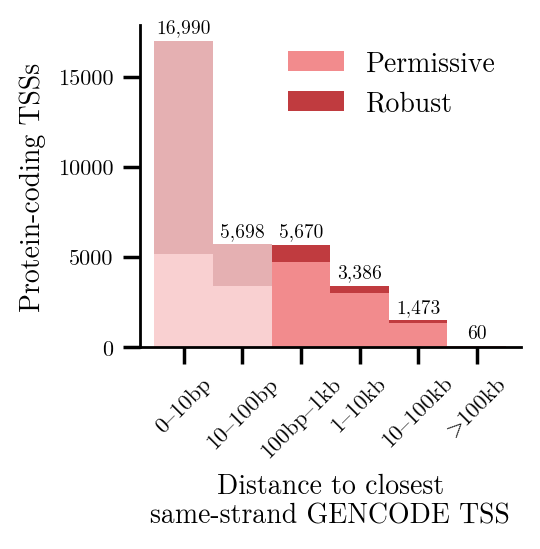

In [40]:
colours = ["#F28B8D", "#C03B3F"]
counts.plot(kind="bar", stacked=True, figsize=(2.8, 2.8), width=1, color = colours)
plt.xlabel("Distance to closest\nsame-strand GENCODE TSS", fontsize=10)
plt.ylabel("Protein-coding TSSs", fontsize=10)
plt.xticks(rotation=45, fontsize = 8) 
plt.yticks(fontsize=8)
plt.legend(title=None , frameon=False, fontsize=10)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

n_bars   = len(counts.index)
n_stacks = len(counts.columns)

for i in (0, 1):               
    for k in range(n_stacks):    
        ax.patches[i + k*n_bars].set_alpha(0.4)

totals = counts.sum(axis=1)
for i, total in enumerate(totals):
    ax.text(
        i,                
        total + 200,            
        f"{total:,}",        
        ha='center', 
        va='bottom', 
        fontsize=7
    )

plt.tight_layout()

plt.savefig("figures/tss_distance.pdf", bbox_inches='tight', dpi=300)
plt.show()

### TSSs in lncRNA transcripts

In [42]:
non_coding_tss = combined_df[(combined_df["gene_category"].isin(["lncRNA"])) & (combined_df["distance_to_closest_TSS"].notna())]

In [43]:
non_coding_tss["bin"] = pd.cut(non_coding_tss["distance_to_closest_TSS"], bins=bin_edges, labels=bin_labels, right=True, include_lowest=True)
counts = non_coding_tss.groupby(["bin", "peak_type"])["peak_name"].nunique().unstack(fill_value=0)
counts

/tmp/19452335/ipykernel_54346/1069495795.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_coding_tss["bin"] = pd.cut(non_coding_tss["distance_to_closest_TSS"], bins=bin_edges, labels=bin_labels, right=True, include_lowest=True)
/tmp/19452335/ipykernel_54346/1069495795.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = non_coding_tss.groupby(["bin", "peak_type"])["peak_name"].nunique().unstack(fill_value=0)


peak_type,Permissive,Robust
bin,,
0–10bp,2504,1457
10–100bp,761,256
100bp–1kb,613,106
1–10kb,252,42
10–100kb,148,31
>100kb,8,6


In [44]:
counts["Permissive"].iloc[-4:].sum()

np.int64(1021)

In [45]:
counts["Robust"].iloc[-4:].sum()

np.int64(185)

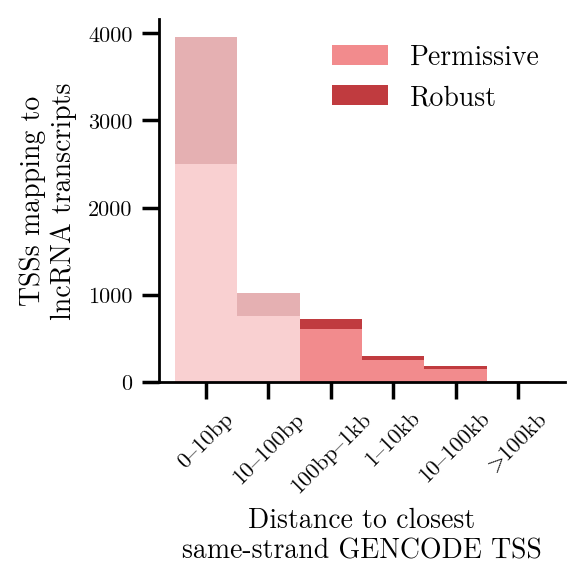

In [50]:
counts.plot(kind="bar", stacked=True, figsize=(3, 3), width=1, color = colours)
plt.xlabel("Distance to closest\nsame-strand GENCODE TSS")
plt.ylabel("TSSs mapping to\nlncRNA transcripts")
plt.xticks(rotation=45)
plt.legend(title=None , frameon=False)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for i in (0, 1):               
    for k in range(n_stacks):    
        ax.patches[i + k*n_bars].set_alpha(0.4)

plt.tight_layout()
plt.show()

### TSSs in unmapped transcripts

In [51]:
unmapped_tss = combined_df[(combined_df["gene_category"] == "unmapped") & (combined_df["distance_to_closest_TSS"].notna())]

In [52]:
unmapped_tss["bin"] = pd.cut(unmapped_tss["distance_to_closest_TSS"], bins=bin_edges, labels=bin_labels, right=True, include_lowest=True)
counts = unmapped_tss.groupby(["bin", "peak_type"])["peak_name"].nunique().unstack(fill_value=0)
counts

/tmp/19452335/ipykernel_54346/3122500490.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unmapped_tss["bin"] = pd.cut(unmapped_tss["distance_to_closest_TSS"], bins=bin_edges, labels=bin_labels, right=True, include_lowest=True)
/tmp/19452335/ipykernel_54346/3122500490.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = unmapped_tss.groupby(["bin", "peak_type"])["peak_name"].nunique().unstack(fill_value=0)


peak_type,Permissive,Robust
bin,,
0–10bp,2,9
10–100bp,8,2
100bp–1kb,127,25
1–10kb,451,53
10–100kb,834,99
>100kb,74,15


In [53]:
counts.values.sum()

np.int64(1699)

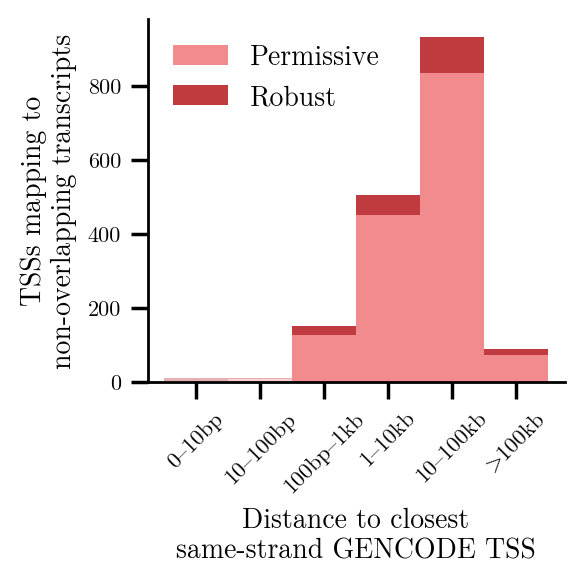

In [54]:
counts.plot(kind="bar", stacked=True, figsize=(3, 3), width=1, color = colours)
plt.xlabel("Distance to closest\nsame-strand GENCODE TSS")
plt.ylabel("TSSs mapping to\nnon-overlapping transcripts")
plt.xticks(rotation=45)
plt.legend(title=None , frameon=False)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for i in (0, 1):               
    for k in range(n_stacks):    
        ax.patches[i + k*n_bars].set_alpha(0.4)

plt.tight_layout()
plt.show()

## Relative TSS usage

In [55]:
combined_df[combined_df["TSS_type"] != "unique TSS"]["Gene stable ID"].nunique()

9692

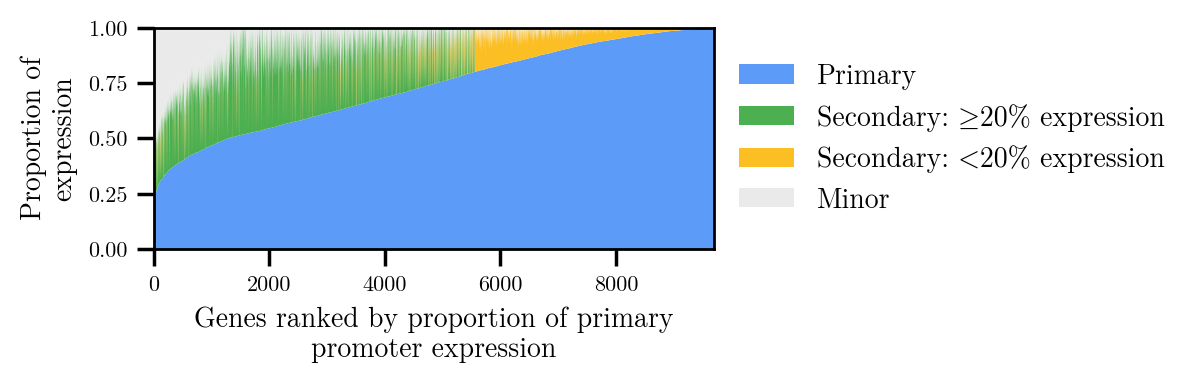

In [67]:
grouped = combined_df[combined_df["TSS_type"] != "unique TSS"].groupby(["Gene stable ID", "TSS_type"])["relative_tx_exp"].sum().reset_index()

pivot = grouped.pivot(index="Gene stable ID", columns="TSS_type", values="relative_tx_exp").fillna(0)


# Reorder columns
ordered_cols = [col for col in ["main TSS", "secondary TSS", "minor TSS"] if col in pivot.columns]
pivot = pivot[ordered_cols]

# Sort genes 
pivot = pivot.sort_values("main TSS", ascending=True)

pivot = pivot.rename(columns={
    "main TSS": "Primary",
    "secondary TSS": "Secondary",
    "minor TSS": "Others"
})

pivot["Secondary_high"] = np.where(pivot["Secondary"] >= 0.2, pivot["Secondary"], 0)
pivot["Secondary_low"]  = np.where(pivot["Secondary"] < 0.2, pivot["Secondary"], 0)

# Plot
colors = {
    "Primary": "#5c9bf7",
    "Secondary_high": "#4CAF50",   
    "Secondary_low": "#FBBF24",    
    "Others": "#EAEAEA"
}

# ["#377eb8", "#e41a1c"]

plt.figure(figsize=(6, 2))
plt.stackplot(
    range(len(pivot)),
    [
        pivot["Primary"],
        pivot["Secondary_high"],
        pivot["Secondary_low"],
        pivot["Others"]
    ],
    labels=["Primary", "Secondary: ≥20% expression", "Secondary: <20% expression", "Minor"],
    colors=[colors["Primary"], colors["Secondary_high"], colors["Secondary_low"], colors["Others"]]
)

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False, fontsize=10)
plt.ylabel("Proportion of\nexpression", fontsize=10)
plt.xlabel("Genes ranked by proportion of primary\npromoter expression", fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.ylim(0, 1)
plt.xlim(0, len(pivot))
plt.tight_layout()
plt.savefig("figures/tss_expression.pdf", bbox_inches='tight', dpi=300)
plt.show()


In [69]:
combined_df["TSS_type"].value_counts()

TSS_type
main TSS         169781
unique TSS       117175
secondary TSS     51115
minor TSS         38271
Name: count, dtype: int64

In [70]:
# Secondary promoters contributing >20% to total expression
secondary_20 = pivot[pivot["Secondary"]>= 0.2]
secondary_20

TSS_type,Primary,Secondary,Others,Secondary_high,Secondary_low
Gene stable ID,,,,,
ENSG00000012061,0.206305,0.202836,0.590859,0.202836,0.0
ENSG00000196924,0.211642,0.207288,0.581070,0.207288,0.0
ENSG00000111885,0.214943,0.208387,0.576670,0.208387,0.0
ENSG00000181722,0.221673,0.218314,0.560013,0.218314,0.0
ENSG00000116539,0.221932,0.209724,0.568344,0.209724,0.0
...,...,...,...,...,...
ENSG00000138311,0.799627,0.200373,0.000000,0.200373,0.0
ENSG00000135976,0.799740,0.200260,0.000000,0.200260,0.0
ENSG00000288602,0.799788,0.200212,0.000000,0.200212,0.0


In [71]:
# Percent of genes where secondary promoter contributes more than 20%
4707 / 9692 * 100

48.565827486586876

In [72]:
secondary_20.index

Index(['ENSG00000012061', 'ENSG00000196924', 'ENSG00000111885',
       'ENSG00000181722', 'ENSG00000116539', 'ENSG00000139209',
       'ENSG00000173064', 'ENSG00000116016', 'ENSG00000134138',
       'ENSG00000055118',
       ...
       'ENSG00000125656', 'ENSG00000221963', 'ENSG00000290831',
       'ENSG00000161542', 'ENSG00000137941', 'ENSG00000138311',
       'ENSG00000135976', 'ENSG00000288602', 'ENSG00000213551',
       'ENSG00000158106'],
      dtype='object', name='Gene stable ID', length=4707)

In [73]:
combined_df[combined_df["Gene stable ID"].isin(secondary_20.index)]["TSS_name"].nunique()

15920

In [75]:
# How many secondary TSSs contribute >20% expression to gene
combined_df[(combined_df["Gene stable ID"].isin(secondary_20.index)) & (combined_df["TSS_type"] == "secondary TSS")]["TSS_name"].nunique()

4680

In [77]:
combined_df[(combined_df["Gene stable ID"].isin(secondary_20.index)) & (combined_df["TSS_type"] == "secondary TSS")].groupby("TSS distance category")["TSS_name"].nunique()

TSS distance category
<=100bp    3031
>100bp     1649
Name: TSS_name, dtype: int64

In [78]:
# How many of secondary promoters (with >20% expression contribution) are unannotated
1649/4680

0.3523504273504274

In [80]:
# What about primary promoters?
combined_df[combined_df["TSS_type"] == "main TSS"].groupby("TSS distance category")["TSS_name"].nunique()

TSS distance category
<=100bp    8578
>100bp      966
Name: TSS_name, dtype: int64

In [81]:
966 / (966 + 8578) * 100

10.12154233025985

In [83]:
tss_multi = combined_df[combined_df["TSS_type"] != "unique TSS"]
tss_multi.loc[tss_multi["TSS_name"].str.endswith("_U"), "TSS_name"].nunique()

10952

In [84]:
top_tss = (
    tss_multi
    .loc[tss_multi.groupby("Gene name")["Relative TSS usage"].idxmax(),
         ["Gene name", "TSS_name", "Relative TSS usage"]]
)

# Count how many of those top TSS end with "_U"
count_genes_u = top_tss["TSS_name"].str.endswith("_U").sum()

print("Number of genes where top TSS ends with _U:", count_genes_u)

Number of genes where top TSS ends with _U: 976


In [85]:
top_tss[top_tss["TSS_name"].str.endswith("_U")]

,Gene name,TSS_name,Relative TSS usage
156849,AASDHPPT,P15201_U,0.595856
308629,ABL1,P77733_U,0.502124
42684,ABLIM1,P11032_U,0.355775
48971,ACACA,P32130_U,0.344485
103350,ACKR2,P52196_U,0.502259
...,...,...,...
91726,ZNF667,P40391_U,0.596097
117620,ZNRF2,P68236_U,0.397726
103291,ZPLD1,P53538_U,0.529278
71490,ZRANB1,P11330_U,0.619928


## Alternative promoter usage of genes

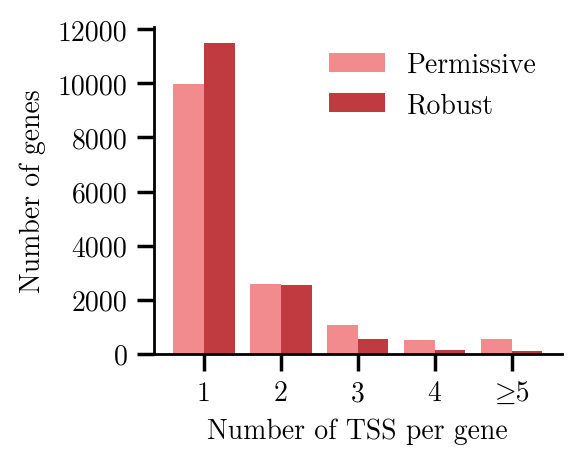

In [88]:
tss_counts = combined_df.groupby(['Gene stable ID', 'peak_type'])['peak_name'].nunique().reset_index()
tss_counts['binned'] = tss_counts['peak_name'].apply(lambda x: x if x < 5 else 5)

tss_counts = tss_counts.groupby(['binned', 'peak_type'])['Gene stable ID'].nunique().unstack(fill_value=0)


labels = ['1', '2', '3', '4', '≥5']
tss_counts = tss_counts.reindex(index=[1,2,3,4,5])  # ensure all bins in order

tss_counts.index = labels
colours = ["#F28B8D", "#C03B3F"]

tss_counts.plot(kind='bar', stacked=False, figsize=(3,2.4), width=0.8, color=colours)
plt.xlabel('Number of TSS per gene', fontsize=10)
plt.ylabel('Number of genes', fontsize=10)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title=None , frameon=False, fontsize=10)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig("figures/tss_number.pdf", bbox_inches='tight', dpi=300)
plt.show()

In [89]:
tss_counts

peak_type,Permissive,Robust
1,9988,11508
2,2592,2534
3,1068,536
4,512,148
≥5,565,100


In [90]:
print(f"Total number of genes with >1 TSS in Robust peak: {tss_counts.loc[['2', '3', '4', '≥5'], 'Robust'].sum()}")

Total number of genes with >1 TSS in Robust peak: 3318


In [91]:
combined_df["Gene stable ID"].nunique()

22015

In [92]:
3318/22015 *100

15.071542130365659

In [93]:
robust = combined_df[combined_df["peak_type"] == "Robust"]

# Identify genes with >1 unique peaks
gene_peak_counts = (robust
    .groupby("Gene stable ID")["peak_name"]
    .nunique()
    .reset_index(name="n_peaks")
)
multi_peak_genes = gene_peak_counts[gene_peak_counts["n_peaks"] > 1]["Gene stable ID"]

# Subset df to just these genes
robust_multi = robust[robust["Gene stable ID"].isin(multi_peak_genes)]

gene_cat_counts = (robust_multi
    .drop_duplicates(subset=["Gene stable ID", "gene_category"])
    .groupby("gene_category")["Gene stable ID"]
    .nunique()
)
print("Genes with >1 Robust peak, by gene_category:")
print(gene_cat_counts)


distance_counts = (robust_multi[robust_multi["gene_category"] == "protein_coding"]
    .groupby("TSS distance category")["peak_name"]
    .nunique()
)
print("\nWithin protein_coding, peaks-per-distance-category:")
print(distance_counts)

Genes with >1 Robust peak, by gene_category:
gene_category
lncRNA              190
other_noncoding      17
protein_coding     3107
unmapped              4
Name: Gene stable ID, dtype: int64

Within protein_coding, peaks-per-distance-category:
TSS distance category
<=100bp    5708
>100bp     1378
Name: peak_name, dtype: int64


In [94]:
robust_multi["Gene stable ID"].nunique()

3318

In [95]:
robust_multi.groupby("TSS distance category")["peak_name"].nunique()

TSS distance category
<=100bp    5998
>100bp     1435
Name: peak_name, dtype: int64

In [96]:
1435/(5998 + 1435) *100

19.30579846629894

## Do different protein coding genes share the same TSS?

In [97]:
tss_gene_counts = protein_coding_tss.groupby("peak_name")["Gene stable ID"].nunique()

shared_tss = tss_gene_counts[tss_gene_counts > 1]

# Get the rows corresponding to shared TSSs
shared_tss_df = protein_coding_tss[protein_coding_tss["peak_name"].isin(shared_tss.index)]
print("Number of TSSs shared by more than one gene:", shared_tss_df["peak_name"].nunique())

Number of TSSs shared by more than one gene: 1355


## Is first exon of protein coding genes completely unannotated?

In [98]:
protein_coding_unannotated_tss = combined_df[(combined_df["gene_category"] == "protein_coding") & 
        (combined_df["distance_to_closest_TSS"] > 100)]


lncrna_unannotated_tss = combined_df[(combined_df["gene_category"] == "lncRNA") & 
        (combined_df["distance_to_closest_TSS"] > 100)]

In [99]:
protein_coding_unannotated_tss["peak_name"].nunique()

10589

In [100]:
lncrna_unannotated_tss["peak_name"].nunique()

1206

In [101]:
# Load gtf of all tx
gtf_column_names = ['Chromosome','source','feature','Start','End','score','Strand','frame','attribute']
gtf_df = pd.read_csv( '../data_processed/curated_HIT.gtf',sep='\t', header=None, names=gtf_column_names)
gtf_df.loc[:, 'transcript_id'] = gtf_df['attribute'].apply(split_attributes, args=("transcript_id",))
gtf_df.head()

,Chromosome,source,feature,Start,End,score,Strand,frame,attribute,transcript_id
0,chr1,custom,exon,61077274,61077628,.,+,.,"gene_id ""ENSG00000162599""; transcript_id ""ENCT...",ENCT00000006334.1
1,chr1,custom,exon,61077916,61079203,.,+,.,"gene_id ""ENSG00000162599""; transcript_id ""ENCT...",ENCT00000006334.1
2,chr1,custom,exon,160261734,160261922,.,+,.,"gene_id ""ENSG00000228606""; transcript_id ""ENCT...",ENCT00000013056.1
3,chr1,custom,exon,160281430,160281892,.,+,.,"gene_id ""ENSG00000228606""; transcript_id ""ENCT...",ENCT00000013056.1
4,chr1,custom,exon,239386568,239387227,.,+,.,"gene_id ""ENSG00000133019""; transcript_id ""ENCT...",ENCT00000019620.1


In [102]:
# Get exons for these tx
gtf_protein_coding_unannotated_tss = gtf_df[gtf_df['transcript_id'].isin(protein_coding_unannotated_tss['transcript_id'])]

gtf_lncrna_unannotated_tss = gtf_df[gtf_df['transcript_id'].isin(lncrna_unannotated_tss['transcript_id'])]

In [103]:
# Keep 1st exon
protein_coding_first_exons = (
    gtf_protein_coding_unannotated_tss.sort_values(
        by=['transcript_id', 'Start'], 
        ascending=[True, True]
    )
    .assign(sort_key=lambda d: d['Start'].where(d['Strand'] == '+', -d['End']))
    .sort_values(['transcript_id', 'sort_key'])
    .drop_duplicates('transcript_id', keep='first')
    .drop(columns='sort_key')
)
protein_coding_first_exons = protein_coding_first_exons.merge(
    protein_coding_unannotated_tss[['transcript_id', 'peak_name']],
    on='transcript_id',
    how='left'
)


lncrna_first_exons = (
    gtf_lncrna_unannotated_tss.sort_values(
        by=['transcript_id', 'Start'], 
        ascending=[True, True]
    )
    .assign(sort_key=lambda d: d['Start'].where(d['Strand'] == '+', -d['End']))
    .sort_values(['transcript_id', 'sort_key'])
    .drop_duplicates('transcript_id', keep='first')
    .drop(columns='sort_key')
)
lncrna_first_exons = lncrna_first_exons.merge(
    lncrna_unannotated_tss[['transcript_id', 'peak_name']],
    on='transcript_id',
    how='left'
)


In [106]:
# Convert to pyranges
protein_coding_first_exons = pr.PyRanges(protein_coding_first_exons)
lncrna_first_exons = pr.PyRanges(lncrna_first_exons)

In [108]:
# Load gencode exons and convert to pyranges
gencode_exons = pd.read_csv("../data_raw/gencode.v47.tsv", sep="\t", dtype=str)
gencode_exons = pr.PyRanges(
    gencode_exons.rename(columns={
        "seqname": "Chromosome",
        "start": "Start",
        "end": "End",
        "strand": "Strand"
    })[["Chromosome", "Start", "End", "Strand", "transcript_id"]]
)
gencode_exons

,Chromosome,Start,End,Strand,transcript_id
0,chr1,11121,11211,+,ENST00000832824.1
1,chr1,12010,12227,+,ENST00000832824.1
2,chr1,12613,12721,+,ENST00000832824.1
3,chr1,13453,14413,+,ENST00000832824.1
4,chr1,11125,11211,+,ENST00000832825.1
...,...,...,...,...,...
2155000,chrY,57214350,57214397,-,ENST00000711270.1
2155001,chrY,57213880,57213964,-,ENST00000711270.1
2155002,chrY,57213526,57213602,-,ENST00000711270.1
2155003,chrY,57213204,57213357,-,ENST00000711270.1


In [109]:
# Find overlaps
overlapping_protein_coding_first_exon = protein_coding_first_exons.overlap(gencode_exons)
overlapping_lncrna_first_exon = lncrna_first_exons.overlap(gencode_exons)

In [110]:
# Protein coding
protein_coding_first_exons = protein_coding_first_exons.df
overlapping_protein_coding_first_exon = overlapping_protein_coding_first_exon.df

non_overlapping_protein_coding_first_exons = protein_coding_first_exons[~protein_coding_first_exons['transcript_id'].isin(
                                                overlapping_protein_coding_first_exon['transcript_id'])]

#lncRNA
lncrna_first_exons = lncrna_first_exons.df
overlapping_lncrna_first_exon = overlapping_lncrna_first_exon.df

non_overlapping_lncrna_first_exons = lncrna_first_exons[~lncrna_first_exons['transcript_id'].isin(
                                                overlapping_lncrna_first_exon['transcript_id'])]

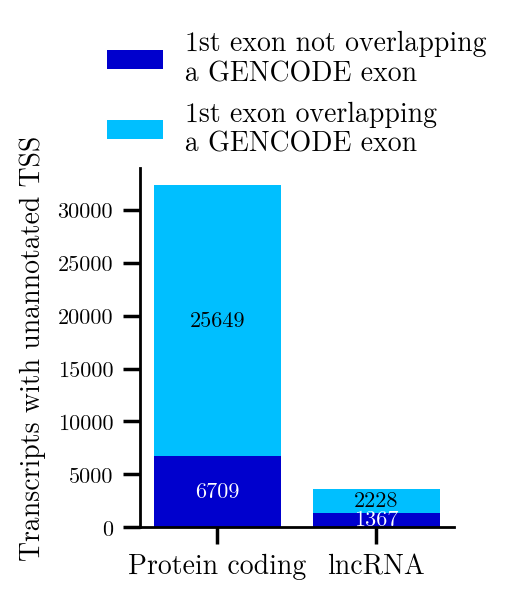

In [111]:
counts_protein_coding = [len(non_overlapping_protein_coding_first_exons), len(overlapping_protein_coding_first_exon)]
counts_lncrna = [len(non_overlapping_lncrna_first_exons), len(overlapping_lncrna_first_exon)]

labels = ["1st exon not overlapping\na GENCODE exon", "1st exon overlapping\na GENCODE exon"]

plt.figure(figsize=(2.5, 3.5))
bar_positions = [0, 1]
bar_labels = ["Protein coding", "lncRNA"]

plt.bar(bar_positions[0], counts_protein_coding[0], label=labels[0], color="mediumblue")
plt.bar(bar_positions[0], counts_protein_coding[1], bottom=counts_protein_coding[0], label=labels[1], color="deepskyblue")

plt.bar(bar_positions[1], counts_lncrna[0], color="mediumblue")
plt.bar(bar_positions[1], counts_lncrna[1], bottom=counts_lncrna[0], color="deepskyblue")

plt.text(bar_positions[0], counts_protein_coding[0] / 2, str(counts_protein_coding[0]), ha='center', va='center', fontsize=8, color='white')
plt.text(bar_positions[0], counts_protein_coding[0] + counts_protein_coding[1] / 2, str(counts_protein_coding[1]), ha='center', va='center', fontsize=8, color='black')

plt.text(bar_positions[1], counts_lncrna[0] / 2, str(counts_lncrna[0]), ha='center', va='center', fontsize=8, color='white')
plt.text(bar_positions[1], counts_lncrna[0] + counts_lncrna[1] / 2, str(counts_lncrna[1]), ha='center', va='center', fontsize=8, color='black')

plt.xticks(bar_positions, bar_labels, fontsize=10)
plt.ylabel("Transcripts with unannotated TSS")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.45), frameon=False)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()


### Plot on TSS level instead of transcript level

In [112]:
# Protein-coding TSSs
set_non_overlapping_protein_coding_first_exons = set(non_overlapping_protein_coding_first_exons["peak_name"])
set_overlapping_protein_coding_first_exon = set(overlapping_protein_coding_first_exon["peak_name"]) - set_non_overlapping_protein_coding_first_exons

print(len(set_overlapping_protein_coding_first_exon) + len(set_non_overlapping_protein_coding_first_exons))

# lncRNA TSSs
set_non_overlapping_lncrna_first_exons = set(non_overlapping_lncrna_first_exons["peak_name"])
set_overlapping_lncrna_first_exon = set(overlapping_lncrna_first_exon["peak_name"]) - set_non_overlapping_lncrna_first_exons

print(len(set_overlapping_lncrna_first_exon) + len(set_non_overlapping_lncrna_first_exons))


10589
1206


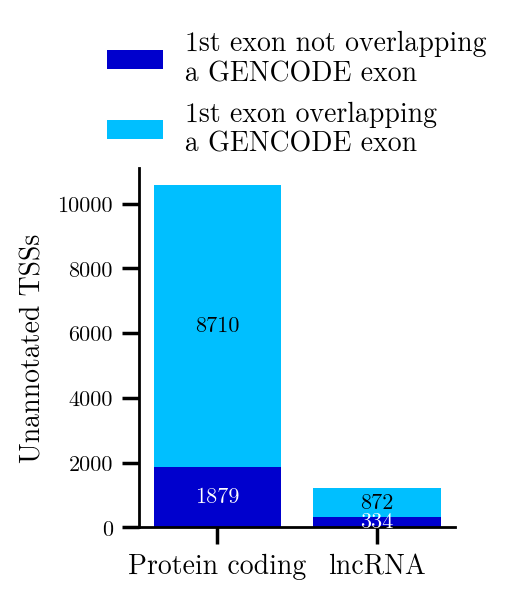

In [113]:
counts_protein_coding = [len(set_non_overlapping_protein_coding_first_exons), len(set_overlapping_protein_coding_first_exon)]
counts_lncrna = [len(set_non_overlapping_lncrna_first_exons), len(set_overlapping_lncrna_first_exon)]

labels = ["1st exon not overlapping\na GENCODE exon", "1st exon overlapping\na GENCODE exon"]

plt.figure(figsize=(2.5, 3.5))
bar_positions = [0, 1]
bar_labels = ["Protein coding", "lncRNA"]

plt.bar(bar_positions[0], counts_protein_coding[0], label=labels[0], color="mediumblue")
plt.bar(bar_positions[0], counts_protein_coding[1], bottom=counts_protein_coding[0], label=labels[1], color="deepskyblue")

plt.bar(bar_positions[1], counts_lncrna[0], color="mediumblue")
plt.bar(bar_positions[1], counts_lncrna[1], bottom=counts_lncrna[0], color="deepskyblue")

plt.text(bar_positions[0], counts_protein_coding[0] / 2, str(counts_protein_coding[0]), ha='center', va='center', fontsize=8, color='white')
plt.text(bar_positions[0], counts_protein_coding[0] + counts_protein_coding[1] / 2, str(counts_protein_coding[1]), ha='center', va='center', fontsize=8, color='black')

plt.text(bar_positions[1], counts_lncrna[0] / 2, str(counts_lncrna[0]), ha='center', va='center', fontsize=8, color='white')
plt.text(bar_positions[1], counts_lncrna[0] + counts_lncrna[1] / 2, str(counts_lncrna[1]), ha='center', va='center', fontsize=8, color='black')

plt.xticks(bar_positions, bar_labels, fontsize=10)
plt.ylabel("Unannotated TSSs")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.45), frameon=False)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()


/tmp/19452335/ipykernel_54346/3797937911.py:38: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


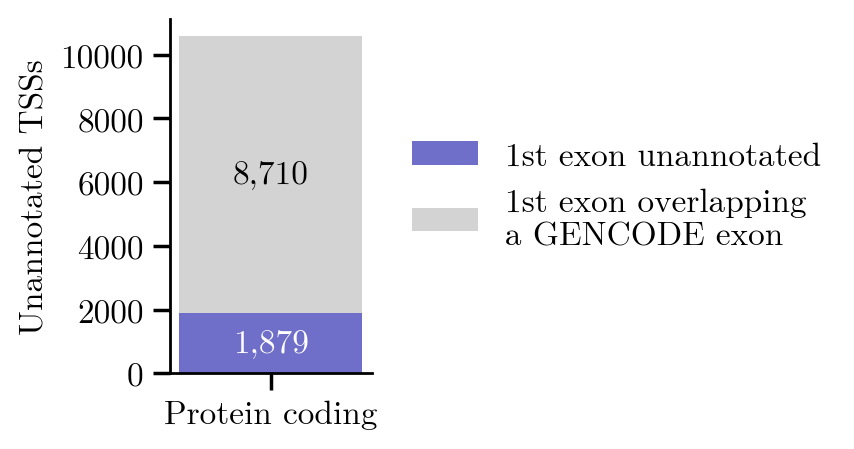

In [115]:
plt.figure(figsize=(1.3, 2.3))

# Data for the protein-coding bar only
counts_protein_coding = [len(set_non_overlapping_protein_coding_first_exons),
                         len(set_overlapping_protein_coding_first_exon)]
labels = ["1st exon unannotated",
          "1st exon overlapping\na GENCODE exon"]

# Single bar at position 0
bar_pos = 0

# Stacked bar
plt.bar(bar_pos, counts_protein_coding[0], label=labels[0], color="#6f6ec8")
plt.bar(bar_pos, counts_protein_coding[1],
        bottom=counts_protein_coding[0], label=labels[1], color="lightgrey")

# Add text labels inside the bar
plt.text(bar_pos, counts_protein_coding[0] / 2, f"{counts_protein_coding[0]:,}",
         ha='center', va='center', fontsize=12, color='white')
plt.text(bar_pos, counts_protein_coding[0] + counts_protein_coding[1] / 2,
         f"{counts_protein_coding[1]:,}", ha='center', va='center', fontsize=12, color='black')

# Axis settings
plt.xticks([bar_pos], ["Protein coding"], fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel("Unannotated TSSs", fontsize=12)
plt.legend(
    loc='center left',
    bbox_to_anchor=(1.05, 0.5),
    frameon=False,
    fontsize=12
)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig("figures/first_exon.pdf", bbox_inches='tight', dpi=300)
plt.show()


In [117]:
# Percentage of unannotated protein coding tx where 1st exon is non-overlapping
1879/10589 *100

17.744829540088773

### Run ORFanage on protein coding tx with non-overlapping 1st exon

In [118]:
non_overlapping_protein_coding_first_exons

,Chromosome,source,feature,Start,End,score,Strand,frame,attribute,transcript_id,peak_name
0,chr1,custom,exon,938827,938950,.,+,.,"gene_id ""ENSG00000187634""; transcript_id ""ENCT...",ENCT00000000083.1,chr1:938656-938830_Peak_62
3,chr1,custom,exon,16013096,16013287,.,+,.,"gene_id ""ENSG00000186510""; transcript_id ""ENCT...",ENCT00000002013.1,chr1:16013071-16013096_Peak_805
4,chr1,custom,exon,16914086,16914137,.,+,.,"gene_id ""ENSG00000058453""; transcript_id ""ENCT...",ENCT00000002137.1,chr1:16914050-16914229_Peak_884
6,chr1,custom,exon,18107495,18107658,.,+,.,"gene_id ""ENSG00000117154""; transcript_id ""ENCT...",ENCT00000002237.1,chr1:18107481-18107503_Peak_935
14,chr1,custom,exon,32539183,32539212,.,+,.,"gene_id ""ENSG00000160062""; transcript_id ""ENCT...",ENCT00000003840.1,chr1:32539150-32539195_Peak_1889
...,...,...,...,...,...,...,...,...,...,...,...
32330,chrX,custom,exon,53683718,53683823,.,-,.,"gene_id ""ENSG00000086758""; transcript_id ""STRT...",STRT02288584,chrX:53683817-53683846_Peak_79094
32331,chrX,custom,exon,54183464,54183545,.,-,.,"gene_id ""ENSG00000184083""; transcript_id ""STRT...",STRT02288825,chrX:54183546-54183581_Peak_79113
32334,chrX,custom,exon,20267800,20267879,.,-,.,"gene_id ""ENSG00000177189""; transcript_id ""STRT...",STRT02291517,chrX:20267913-20267917_Peak_78466
32343,chrY,custom,exon,6909885,6910103,.,+,.,"gene_id ""ENSG00000092377""; transcript_id ""STRT...",STRT02292300,chrY:6909846-6909865_Peak_80713


In [119]:
# get exons of entire transcript
tx_non_overlapping_protein_coding_first_exons = gtf_df[gtf_df["transcript_id"].isin(non_overlapping_protein_coding_first_exons["transcript_id"])]

In [120]:
tx_non_overlapping_protein_coding_first_exons

,Chromosome,source,feature,Start,End,score,Strand,frame,attribute,transcript_id
597129,chr1,custom,exon,938827,938950,.,+,.,"gene_id ""ENSG00000187634""; transcript_id ""ENCT...",ENCT00000000083.1
597130,chr1,custom,exon,939040,939129,.,+,.,"gene_id ""ENSG00000187634""; transcript_id ""ENCT...",ENCT00000000083.1
597131,chr1,custom,exon,939272,939412,.,+,.,"gene_id ""ENSG00000187634""; transcript_id ""ENCT...",ENCT00000000083.1
597132,chr1,custom,exon,941144,941306,.,+,.,"gene_id ""ENSG00000187634""; transcript_id ""ENCT...",ENCT00000000083.1
597133,chr1,custom,exon,942136,942251,.,+,.,"gene_id ""ENSG00000187634""; transcript_id ""ENCT...",ENCT00000000083.1
...,...,...,...,...,...,...,...,...,...,...
3468110,chrX,custom,exon,107153955,107154246,.,-,.,"gene_id ""ENSG00000198088""; transcript_id ""STRT...",STRT02287569
3468111,chrX,custom,exon,107155760,107156202,.,-,.,"gene_id ""ENSG00000198088""; transcript_id ""STRT...",STRT02287569
3468116,chrX,custom,exon,104100239,104106299,.,-,.,"gene_id ""ENSG00000269743""; transcript_id ""STRT...",STRT02288477
3468117,chrX,custom,exon,104110502,104111473,.,-,.,"gene_id ""ENSG00000269743""; transcript_id ""STRT...",STRT02288477


In [121]:
# Add transcript features (needed for ORFanage)

# Group by transcript_id to get transcript boundaries
transcripts = (
    tx_non_overlapping_protein_coding_first_exons.groupby("transcript_id")
    .agg({
        "Chromosome": "first",
        "source": "first",
        "Start": "min",
        "End": "max",
        "Strand": "first",
        "attribute": "first"
    })
    .reset_index()
)

# Add the required columns for transcript entries
transcripts["feature"] = "transcript"
transcripts["score"] = "."
transcripts["frame"] = "."
transcripts = transcripts[[
    "Chromosome", "source", "feature", "Start", "End", "score", "Strand", "frame", "attribute", "transcript_id"
]]

# Append transcript rows to original DataFrame
tx_non_overlapping_protein_coding_first_exons = pd.concat([transcripts, tx_non_overlapping_protein_coding_first_exons], ignore_index=True)

# Sort by Chromosome, Start
tx_non_overlapping_protein_coding_first_exons = tx_non_overlapping_protein_coding_first_exons.sort_values(["Chromosome", "Start"]).reset_index(drop=True)


In [122]:
tx_non_overlapping_protein_coding_first_exons["transcript_id"].nunique()

6709

In [124]:
tx_non_overlapping_protein_coding_first_exons

,Chromosome,source,feature,Start,End,score,Strand,frame,attribute,transcript_id
0,chr1,custom,transcript,938694,944574,.,+,.,"gene_id ""ENSG00000187634""; transcript_id ""STRT...",STRT00176417
1,chr1,custom,exon,938694,938950,.,+,.,"gene_id ""ENSG00000187634""; transcript_id ""STRT...",STRT00176417
2,chr1,custom,transcript,938749,944799,.,+,.,"gene_id ""ENSG00000187634""; transcript_id ""FTMT...",FTMT20300104690.1
3,chr1,custom,exon,938749,938950,.,+,.,"gene_id ""ENSG00000187634""; transcript_id ""FTMT...",FTMT20300104690.1
4,chr1,custom,transcript,938827,944267,.,+,.,"gene_id ""ENSG00000187634""; transcript_id ""ENCT...",ENCT00000000083.1
...,...,...,...,...,...,...,...,...,...,...
92856,chrY,custom,exon,6912088,6912172,.,+,.,"gene_id ""ENSG00000092377""; transcript_id ""STRT...",STRT02292300
92857,chrY,custom,exon,6912088,6912172,.,+,.,"gene_id ""ENSG00000092377""; transcript_id ""STRT...",STRT02295179
92858,chrY,custom,exon,6914579,6914808,.,+,.,"gene_id ""ENSG00000092377""; transcript_id ""STRT...",STRT02292300
92859,chrY,custom,exon,6914579,6924255,.,+,.,"gene_id ""ENSG00000092377""; transcript_id ""STRT...",STRT02295179


In [125]:
tx_non_overlapping_protein_coding_first_exons = tx_non_overlapping_protein_coding_first_exons.drop(columns=["transcript_id"])

In [126]:
# Save gtf
tx_non_overlapping_protein_coding_first_exons.to_csv('../data_processed/ORFanage/non-overlap_1st_exons_for_orfanage.gtf', sep='\t', header=False, index=False, quoting=csv.QUOTE_NONE)

orfanage --reference /no_backup/jferrer/mplanas/VASAseq/files/hg38.fa --query /no_backup/jferrer/jmidgley/ORFanage/non-overlap_1st_exons_for_orfanage.gtf --output non-overlap_1st_exons_ORFanage_output.gtf /no_backup/jferrer/jmidgley/gencode.v47.annotation.gtf

In [127]:
orfanage_output = pd.read_csv( '../data_processed//ORFanage/non-overlap_1st_exons_ORFanage_output.gtf',
                           sep='\t', header=None, names=gtf_column_names)
orfanage_output.loc[:, 'transcript_id'] = orfanage_output['attribute'].apply(split_attributes, args=("transcript_id",))

orfanage_output

,Chromosome,source,feature,Start,End,score,Strand,frame,attribute,transcript_id
0,chr1,custom,transcript,938694,944574,.,+,.,"transcript_id ""STRT00176417""; gene_id ""ENSG000...",STRT00176417
1,chr1,custom,exon,938694,938950,.,+,.,"transcript_id ""STRT00176417"";",STRT00176417
2,chr1,custom,exon,939040,939129,.,+,.,"transcript_id ""STRT00176417"";",STRT00176417
3,chr1,custom,exon,939275,939412,.,+,.,"transcript_id ""STRT00176417"";",STRT00176417
4,chr1,custom,exon,941144,941306,.,+,.,"transcript_id ""STRT00176417"";",STRT00176417
...,...,...,...,...,...,...,...,...,...,...
153246,chrY,custom,exon,6915592,6920747,.,+,.,"transcript_id ""STRT02292300"";",STRT02292300
153247,chrY,custom,transcript,6909910,6924255,.,+,.,"transcript_id ""STRT02295179""; gene_id ""ENSG000...",STRT02295179
153248,chrY,custom,exon,6909910,6910103,.,+,.,"transcript_id ""STRT02295179"";",STRT02295179
153249,chrY,custom,exon,6912088,6912172,.,+,.,"transcript_id ""STRT02295179"";",STRT02295179


In [128]:
orfanage_output["transcript_id"].nunique()

6709

In [129]:
# Keep only ORFanage output for transcripts where a CDS could be predicted
cds_rows = orfanage_output[orfanage_output["feature"] == "CDS"]
transcripts_with_cds = cds_rows["transcript_id"].unique()


orfanage_output_with_CDS = orfanage_output[orfanage_output["transcript_id"].isin(transcripts_with_cds)]

print(orfanage_output_with_CDS["transcript_id"].nunique())

5635


In [130]:
# Keep only CDS rows where frame is 0
orfanage_output_with_CDS = orfanage_output_with_CDS[
    (orfanage_output_with_CDS["feature"] != "CDS") | (orfanage_output_with_CDS["frame"] == "0")
]

In [131]:
# Build a set of unique exon keys from first exons
first_exons = set(
    tuple(x) for x in non_overlapping_protein_coding_first_exons[["Chromosome", "Start", "End", "transcript_id", "Strand"]].values
)

# Mark first exons
orfanage_output_with_CDS["is_first_exon"] = orfanage_output_with_CDS.apply(
    lambda row: (
        (row["Chromosome"], row["Start"], row["End"], row["transcript_id"], row["Strand"]) in first_exons
    ) if row["feature"] == "exon" else False,
    axis=1
)

In [132]:
orfanage_output_with_CDS

,Chromosome,source,feature,Start,End,score,Strand,frame,attribute,transcript_id,is_first_exon
0,chr1,custom,transcript,938694,944574,.,+,.,"transcript_id ""STRT00176417""; gene_id ""ENSG000...",STRT00176417,False
1,chr1,custom,exon,938694,938950,.,+,.,"transcript_id ""STRT00176417"";",STRT00176417,True
2,chr1,custom,exon,939040,939129,.,+,.,"transcript_id ""STRT00176417"";",STRT00176417,False
3,chr1,custom,exon,939275,939412,.,+,.,"transcript_id ""STRT00176417"";",STRT00176417,False
4,chr1,custom,exon,941144,941306,.,+,.,"transcript_id ""STRT00176417"";",STRT00176417,False
...,...,...,...,...,...,...,...,...,...,...,...
153204,chrX,custom,exon,150814862,150814936,.,-,.,"transcript_id ""STRT02275241"";",STRT02275241,False
153205,chrX,custom,exon,150816007,150816078,.,-,.,"transcript_id ""STRT02275241"";",STRT02275241,False
153206,chrX,custom,exon,150831231,150831293,.,-,.,"transcript_id ""STRT02275241"";",STRT02275241,False
153207,chrX,custom,exon,150854811,150854906,.,-,.,"transcript_id ""STRT02275241"";",STRT02275241,True


In [133]:
# Mark predicted CDS that match first exon with at least one end
exons = orfanage_output_with_CDS[(orfanage_output_with_CDS["feature"] == "exon") & (orfanage_output_with_CDS["is_first_exon"] == True)].copy()
exon_start_keys = set(zip(exons["Chromosome"],
                          exons["Start"],
                          exons["transcript_id"],
                          exons["Strand"]))
exon_end_keys   = set(zip(exons["Chromosome"],
                          exons["End"].astype(int),
                          exons["transcript_id"],
                          exons["Strand"]))

# Flag CDS rows whose start OR end matches an exon boundary
orfanage_output_with_CDS["CDS_matches_exon"] = orfanage_output_with_CDS.apply(
    lambda row: (
        (row["Chromosome"], row["Start"], row["transcript_id"], row["Strand"]) in exon_start_keys
        or
        (row["Chromosome"], row["End"],   row["transcript_id"], row["Strand"]) in exon_end_keys
    ) if row["feature"] == "CDS" else False,
    axis=1
)

In [134]:
orfanage_output_with_CDS

,Chromosome,source,feature,Start,End,score,Strand,frame,attribute,transcript_id,is_first_exon,CDS_matches_exon
0,chr1,custom,transcript,938694,944574,.,+,.,"transcript_id ""STRT00176417""; gene_id ""ENSG000...",STRT00176417,False,False
1,chr1,custom,exon,938694,938950,.,+,.,"transcript_id ""STRT00176417"";",STRT00176417,True,False
2,chr1,custom,exon,939040,939129,.,+,.,"transcript_id ""STRT00176417"";",STRT00176417,False,False
3,chr1,custom,exon,939275,939412,.,+,.,"transcript_id ""STRT00176417"";",STRT00176417,False,False
4,chr1,custom,exon,941144,941306,.,+,.,"transcript_id ""STRT00176417"";",STRT00176417,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
153204,chrX,custom,exon,150814862,150814936,.,-,.,"transcript_id ""STRT02275241"";",STRT02275241,False,False
153205,chrX,custom,exon,150816007,150816078,.,-,.,"transcript_id ""STRT02275241"";",STRT02275241,False,False
153206,chrX,custom,exon,150831231,150831293,.,-,.,"transcript_id ""STRT02275241"";",STRT02275241,False,False
153207,chrX,custom,exon,150854811,150854906,.,-,.,"transcript_id ""STRT02275241"";",STRT02275241,True,False


In [135]:
# Only keep transcripts where CDS matches the unannotated exon
valid_ids = orfanage_output_with_CDS[(orfanage_output_with_CDS["CDS_matches_exon"] == True)]["transcript_id"].unique()

orfanage_output_with_CDS = orfanage_output_with_CDS[
    orfanage_output_with_CDS["transcript_id"].isin(valid_ids)
]


print(orfanage_output_with_CDS["transcript_id"].nunique())

546


In [136]:
orfanage_output_with_CDS[(orfanage_output_with_CDS["feature"] == "CDS") & (orfanage_output_with_CDS["CDS_matches_exon"] == True)]

,Chromosome,source,feature,Start,End,score,Strand,frame,attribute,transcript_id,is_first_exon,CDS_matches_exon
191,chr1,ORFanage,CDS,15724187,15724301,.,+,0,"transcript_id ""PBT00032272"";",PBT00032272,False,True
3273,chr1,ORFanage,CDS,43559011,43559065,.,+,0,"transcript_id ""PBT00033330"";",PBT00033330,False,True
3333,chr1,ORFanage,CDS,43559011,43559065,.,+,0,"transcript_id ""PBT00033331"";",PBT00033331,False,True
3765,chr1,ORFanage,CDS,74734396,74734446,.,+,0,"transcript_id ""STRT00085127"";",STRT00085127,False,True
5419,chr1,ORFanage,CDS,147612717,147612754,.,+,0,"transcript_id ""STRT00128650"";",STRT00128650,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
152952,chrX,ORFanage,CDS,107118431,107118543,.,-,0,"transcript_id ""STRT02256479"";",STRT02256479,False,True
152967,chrX,ORFanage,CDS,107118431,107118543,.,-,0,"transcript_id ""PBT00440623"";",PBT00440623,False,True
152976,chrX,ORFanage,CDS,107118431,107118543,.,-,0,"transcript_id ""STRT02285019"";",STRT02285019,False,True
152991,chrX,ORFanage,CDS,107156027,107156217,.,-,0,"transcript_id ""STRT02263808"";",STRT02263808,False,True


In [137]:
import pickle

with open("../data_processed/ORFanage/orfanage_output_with_CDS_first_exons.pkl", "wb") as f:
    pickle.dump(orfanage_output_with_CDS, f)

In [139]:
# How many genes have unannotated first exon in CDS?
combined_df[combined_df["transcript_id"].isin(orfanage_output_with_CDS["transcript_id"].unique())]["Gene stable ID"].nunique()

247

In [140]:
# Which genes?
genes_with_first_exon_CDS = set(combined_df[combined_df["transcript_id"].isin(orfanage_output_with_CDS["transcript_id"].unique())]["Gene name"].unique())
genes_with_first_exon_CDS

{'ABI1',
 'ABLIM1',
 'ABLIM3',
 'ABR',
 'ACLY',
 'ACMSD',
 'ADAM9',
 'ADAMTS12',
 'ADCY5',
 'AGPAT5',
 'AGPS',
 'AHRR',
 'ALOX5AP',
 'ANK2',
 'ANKRD44',
 'ANO5',
 'AQP1',
 'ASPH',
 'ASXL3',
 'ATG2B',
 'ATP9A',
 'ATXN10',
 'BACE1',
 'BACH1',
 'BAIAP2',
 'BCAT2',
 'BCL9',
 'BRAP',
 'C8orf76',
 'CACNA1D',
 'CACNA2D1',
 'CACNA2D2',
 'CACNB2',
 'CAPZB',
 'CARNMT1',
 'CATSPERE',
 'CCDC61',
 'CCND1',
 'CCT8',
 'CD109',
 'CD5',
 'CDK19',
 'CERKL',
 'CHCHD6',
 'CLIC1',
 'CLMN',
 'CLPSL1',
 'CMTM8',
 'COL28A1',
 'CRADD',
 'DCDC1',
 'DHRS7B',
 'DIP2C',
 'DOCK4',
 'DPYD',
 'DSCAML1',
 'DYNC2I1',
 'EFNA1',
 'EHF',
 'EIF2S1',
 'EIF3H',
 'ELAPOR2',
 'EML5',
 'ENPP2',
 'ENSG00000249319',
 'ENTHD1',
 'EPHA2',
 'ERCC1',
 'ERICH1',
 'ERP27',
 'EXOC6B',
 'FEV',
 'FGF12',
 'FGF9',
 'FMN1',
 'FMO1',
 'FNTB',
 'FOXP2',
 'FSTL4',
 'GAB2',
 'GGA2',
 'GHSR',
 'GLI3',
 'GMDS',
 'GPR37L1',
 'GRAMD1B',
 'GRAMD4',
 'GRIP1',
 'GRM8',
 'GSE1',
 'H2AZ2',
 'HIP1',
 'HMGCLL1',
 'HOOK2',
 'IGF1R',
 'IGFBP5',
 'INSC',
 'K

### Is non-overlapping exon in intron region of GENCODE transcripts or outside of transcripts?

In [142]:
# Add gene ID & name column 
non_overlapping_protein_coding_first_exons.loc[:, 'gene_id'] = non_overlapping_protein_coding_first_exons['attribute'].apply(split_attributes, args=("gene_id",))
non_overlapping_protein_coding_first_exons.loc[:, 'gene_name'] = non_overlapping_protein_coding_first_exons['attribute'].apply(split_attributes, args=("gene_name",))

non_overlapping_protein_coding_first_exons.head()

/tmp/19452335/ipykernel_54346/724753300.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_overlapping_protein_coding_first_exons.loc[:, 'gene_id'] = non_overlapping_protein_coding_first_exons['attribute'].apply(split_attributes, args=("gene_id",))
/tmp/19452335/ipykernel_54346/724753300.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_overlapping_protein_coding_first_exons.loc[:, 'gene_name'] = non_overlapping_protein_coding_first_exons['attribute'].apply(split_attributes, args=("gene_name",))


,Chromosome,source,feature,Start,End,score,Strand,frame,attribute,transcript_id,peak_name,gene_id,gene_name
0,chr1,custom,exon,938827,938950,.,+,.,"gene_id ""ENSG00000187634""; transcript_id ""ENCT...",ENCT00000000083.1,chr1:938656-938830_Peak_62,ENSG00000187634,SAMD11
3,chr1,custom,exon,16013096,16013287,.,+,.,"gene_id ""ENSG00000186510""; transcript_id ""ENCT...",ENCT00000002013.1,chr1:16013071-16013096_Peak_805,ENSG00000186510,CLCNKA
4,chr1,custom,exon,16914086,16914137,.,+,.,"gene_id ""ENSG00000058453""; transcript_id ""ENCT...",ENCT00000002137.1,chr1:16914050-16914229_Peak_884,ENSG00000058453,CROCC
6,chr1,custom,exon,18107495,18107658,.,+,.,"gene_id ""ENSG00000117154""; transcript_id ""ENCT...",ENCT00000002237.1,chr1:18107481-18107503_Peak_935,ENSG00000117154,IGSF21
14,chr1,custom,exon,32539183,32539212,.,+,.,"gene_id ""ENSG00000160062""; transcript_id ""ENCT...",ENCT00000003840.1,chr1:32539150-32539195_Peak_1889,ENSG00000160062,ZBTB8A


In [143]:
# Create stripped version of gene ID to match with other df
gencode_v47_transcripts['stripped_gene_id'] = gencode_v47_transcripts['gene_id'].str.replace(r'\.\d+$', '', regex=True)
gencode_v47_transcripts.head()

,chr,source,feature,start,end,score,strand,frame,gene_id,transcript_id,gene_type,gene_name,transcript_type,transcript_name,level,tag,transcript_support_level,havana_transcript,hgnc_id,ont,havana_gene,protein_id,ccdsid,stripped_gene_id
0,chr1,HAVANA,transcript,11121,14413,.,+,.,ENSG00000290825.2,ENST00000832824.1,lncRNA,DDX11L16,lncRNA,DDX11L16-260,2,TAGENE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ENSG00000290825
1,chr1,HAVANA,transcript,11125,14405,.,+,.,ENSG00000290825.2,ENST00000832825.1,lncRNA,DDX11L16,lncRNA,DDX11L16-261,2,TAGENE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ENSG00000290825
2,chr1,HAVANA,transcript,11410,14413,.,+,.,ENSG00000290825.2,ENST00000832826.1,lncRNA,DDX11L16,lncRNA,DDX11L16-262,2,TAGENE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ENSG00000290825
3,chr1,HAVANA,transcript,11411,14413,.,+,.,ENSG00000290825.2,ENST00000832827.1,lncRNA,DDX11L16,lncRNA,DDX11L16-263,2,TAGENE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ENSG00000290825
4,chr1,HAVANA,transcript,11426,14409,.,+,.,ENSG00000290825.2,ENST00000832828.1,lncRNA,DDX11L16,lncRNA,DDX11L16-264,2,TAGENE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ENSG00000290825


In [144]:
# Keep only the ref tx of the genes which contain the HIT tx with non-overlapping first exons
ref_tx = gencode_v47_transcripts[gencode_v47_transcripts["stripped_gene_id"].isin(non_overlapping_protein_coding_first_exons["gene_id"].unique())]

In [145]:
ref_tx

,chr,source,feature,start,end,score,strand,frame,gene_id,transcript_id,gene_type,gene_name,transcript_type,transcript_name,level,tag,transcript_support_level,havana_transcript,hgnc_id,ont,havana_gene,protein_id,ccdsid,stripped_gene_id
1201,chr1,HAVANA,transcript,923923,944574,.,+,.,ENSG00000187634.13,ENST00000616016.5,protein_coding,SAMD11,protein_coding,SAMD11-209,2,CCDS,5,OTTHUMT00000316521.3,HGNC:28706,NaN,OTTHUMG00000040719.11,ENSP00000478421.2,CCDS90834.1,ENSG00000187634
1202,chr1,HAVANA,transcript,923923,944574,.,+,.,ENSG00000187634.13,ENST00000618323.5,protein_coding,SAMD11,protein_coding,SAMD11-213,2,CCDS,5,NaN,HGNC:28706,NaN,OTTHUMG00000040719.11,ENSP00000480678.2,CCDS90833.1,ENSG00000187634
1203,chr1,HAVANA,transcript,925150,935793,.,+,.,ENSG00000187634.13,ENST00000437963.5,protein_coding,SAMD11,protein_coding,SAMD11-203,2,alternative_5_UTR,5,OTTHUMT00000097862.5,HGNC:28706,NaN,OTTHUMG00000040719.11,ENSP00000393181.1,NaN,ENSG00000187634
1204,chr1,HAVANA,transcript,925731,944574,.,+,.,ENSG00000187634.13,ENST00000342066.8,protein_coding,SAMD11,protein_coding,SAMD11-202,2,CCDS,5,OTTHUMT00000276866.3,HGNC:28706,NaN,OTTHUMG00000040719.11,ENSP00000342313.3,CCDS2.2,ENSG00000187634
1205,chr1,HAVANA,transcript,925942,944153,.,+,.,ENSG00000187634.13,ENST00000616125.5,protein_coding,SAMD11,protein_coding,SAMD11-210,2,cds_start_NF,5,NaN,HGNC:28706,NaN,OTTHUMG00000040719.11,ENSP00000484643.1,NaN,ENSG00000187634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383326,chrX,HAVANA,transcript,154364632,154365207,.,-,.,ENSG00000196924.19,ENST00000465144.1,protein_coding,FLNA,retained_intron,FLNA-210,2,NaN,2,OTTHUMT00000130298.1,HGNC:3754,NaN,OTTHUMG00000022712.33,NaN,NaN,ENSG00000196924
384232,chrY,HAVANA,transcript,6910686,7091683,.,+,.,ENSG00000092377.15,ENST00000346432.3,protein_coding,TBL1Y,protein_coding,TBL1Y-201,2,CCDS,1,OTTHUMT00000085362.1,HGNC:18502,NaN,OTTHUMG00000035299.3,ENSP00000328879.4,CCDS14779.1,ENSG00000092377
384233,chrY,HAVANA,transcript,6910686,7091683,.,+,.,ENSG00000092377.15,ENST00000355162.6,protein_coding,TBL1Y,protein_coding,TBL1Y-202,2,CCDS,1,OTTHUMT00000085361.1,HGNC:18502,NaN,OTTHUMG00000035299.3,ENSP00000347289.2,CCDS14779.1,ENSG00000092377
384234,chrY,HAVANA,transcript,6910697,7091683,.,+,.,ENSG00000092377.15,ENST00000383032.6,protein_coding,TBL1Y,protein_coding,TBL1Y-203,2,CCDS,1,OTTHUMT00000085360.2,HGNC:18502,NaN,OTTHUMG00000035299.3,ENSP00000372499.1,CCDS14779.1,ENSG00000092377


In [146]:
# Convert to pyranges
exons_pr = pr.PyRanges(non_overlapping_protein_coding_first_exons)

tx_pr = pr.PyRanges(ref_tx.rename(columns={"chr": "Chromosome", "start": "Start", "end": "End", "strand": "Strand"})[
        ["Chromosome", "Start", "End", "Strand", "transcript_id", "stripped_gene_id"]])


In [147]:
joined = exons_pr.join(tx_pr, suffix="_tx")

join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


In [148]:
# Find the exons that are contained in ref tx
fully_contained = joined.df[
    (joined.df["Start"] >= joined.df["Start_tx"]) &
    (joined.df["End"] <= joined.df["End_tx"]) &
    (joined.df["gene_id"] == joined.df["stripped_gene_id"])
]
fully_contained.head()

,Chromosome,source,feature,Start,End,score,Strand,frame,attribute,transcript_id,peak_name,gene_id,gene_name,Start_tx,End_tx,Strand_tx,transcript_id_tx,stripped_gene_id
0,chr1,custom,exon,938827,938950,.,+,.,"gene_id ""ENSG00000187634""; transcript_id ""ENCT...",ENCT00000000083.1,chr1:938656-938830_Peak_62,ENSG00000187634,SAMD11,923923,944574,+,ENST00000616016.5,ENSG00000187634
1,chr1,custom,exon,938827,938950,.,+,.,"gene_id ""ENSG00000187634""; transcript_id ""ENCT...",ENCT00000000083.1,chr1:938656-938830_Peak_62,ENSG00000187634,SAMD11,923923,944574,+,ENST00000618323.5,ENSG00000187634
2,chr1,custom,exon,938827,938950,.,+,.,"gene_id ""ENSG00000187634""; transcript_id ""ENCT...",ENCT00000000083.1,chr1:938656-938830_Peak_62,ENSG00000187634,SAMD11,925731,944574,+,ENST00000342066.8,ENSG00000187634
3,chr1,custom,exon,938827,938950,.,+,.,"gene_id ""ENSG00000187634""; transcript_id ""ENCT...",ENCT00000000083.1,chr1:938656-938830_Peak_62,ENSG00000187634,SAMD11,925942,944153,+,ENST00000616125.5,ENSG00000187634
4,chr1,custom,exon,938827,938950,.,+,.,"gene_id ""ENSG00000187634""; transcript_id ""ENCT...",ENCT00000000083.1,chr1:938656-938830_Peak_62,ENSG00000187634,SAMD11,925942,944153,+,ENST00000618779.5,ENSG00000187634


In [149]:
# Add info as column to original df
non_overlapping_protein_coding_first_exons["is_contained"] = non_overlapping_protein_coding_first_exons["transcript_id"].isin(fully_contained["transcript_id"].unique())
non_overlapping_protein_coding_first_exons.head()

/tmp/19452335/ipykernel_54346/635989619.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_overlapping_protein_coding_first_exons["is_contained"] = non_overlapping_protein_coding_first_exons["transcript_id"].isin(fully_contained["transcript_id"].unique())


,Chromosome,source,feature,Start,End,score,Strand,frame,attribute,transcript_id,peak_name,gene_id,gene_name,is_contained
0,chr1,custom,exon,938827,938950,.,+,.,"gene_id ""ENSG00000187634""; transcript_id ""ENCT...",ENCT00000000083.1,chr1:938656-938830_Peak_62,ENSG00000187634,SAMD11,True
3,chr1,custom,exon,16013096,16013287,.,+,.,"gene_id ""ENSG00000186510""; transcript_id ""ENCT...",ENCT00000002013.1,chr1:16013071-16013096_Peak_805,ENSG00000186510,CLCNKA,False
4,chr1,custom,exon,16914086,16914137,.,+,.,"gene_id ""ENSG00000058453""; transcript_id ""ENCT...",ENCT00000002137.1,chr1:16914050-16914229_Peak_884,ENSG00000058453,CROCC,True
6,chr1,custom,exon,18107495,18107658,.,+,.,"gene_id ""ENSG00000117154""; transcript_id ""ENCT...",ENCT00000002237.1,chr1:18107481-18107503_Peak_935,ENSG00000117154,IGSF21,False
14,chr1,custom,exon,32539183,32539212,.,+,.,"gene_id ""ENSG00000160062""; transcript_id ""ENCT...",ENCT00000003840.1,chr1:32539150-32539195_Peak_1889,ENSG00000160062,ZBTB8A,False


In [150]:
non_overlapping_protein_coding_first_exons["is_contained"].value_counts()

is_contained
True     5295
False    1414
Name: count, dtype: int64

In [151]:
non_overlapping_protein_coding_first_exons[non_overlapping_protein_coding_first_exons["gene_id"] == "ENSG00000153956"]

,Chromosome,source,feature,Start,End,score,Strand,frame,attribute,transcript_id,peak_name,gene_id,gene_name,is_contained
13331,chr7,custom,exon,82335920,82335955,.,-,.,"gene_id ""ENSG00000153956""; transcript_id ""PBT0...",PBT00392775,chr7:82335974-82336008_Peak_69353,ENSG00000153956,CACNA2D1,True


In [152]:
# % of exons outside of ref tx region
1414/(1414+5295) *100

21.076166343717397

In [153]:
# Which genes have first exons outside of ref tx region?
genes_with_first_exon_outside = set(non_overlapping_protein_coding_first_exons[non_overlapping_protein_coding_first_exons["is_contained"] == False]["gene_name"])

In [154]:
genes_with_first_exon_CDS & genes_with_first_exon_outside

{'AGPAT5',
 'ANK2',
 'AQP1',
 'ATP9A',
 'BCAT2',
 'CATSPERE',
 'CCT8',
 'CD109',
 'EFNA1',
 'ENPP2',
 'FEV',
 'FSTL4',
 'GHSR',
 'GPR37L1',
 'HMGCLL1',
 'LMO1',
 'MAPRE1',
 'ME3',
 'MYBPHL',
 'NLGN1',
 'PARVA',
 'PDE3A',
 'PDE8B',
 'PTPRF',
 'RAP1GAP2',
 'RFX6',
 'RGPD5',
 'SAMD15',
 'SHC2',
 'SLC12A7',
 'SNX3',
 'SORL1',
 'SRCIN1',
 'SYNJ2',
 'SYT17',
 'SYT7',
 'TARS1',
 'TENT5B',
 'TMEM164',
 'VOPP1',
 'ZBTB47',
 'ZC3H12C',
 'ZNF365'}

## Plot relative TSS usage of protein coding genes

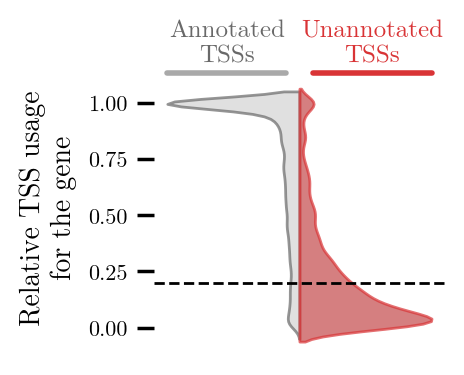

In [157]:
fig, ax1 = plt.subplots(figsize=(2.4, 2))

sns.violinplot(
    x="gene_category",
    y="Relative TSS usage",
    hue="TSS distance category",
    split=True,
    inner=None,
    palette={"<=100bp": "lightgrey", ">100bp": "#d93436"},
    alpha=0.7,
    data=protein_coding_tss,
    ax=ax1
)

for i, violin in enumerate(ax1.collections):
    # Left sides (first half of violins)
    if i % 2 == 0:
        violin.set_edgecolor("dimgrey")        # left outline color
        violin.set_linewidth(1)
    else:
        violin.set_edgecolor("#d93436")   # right outline color
        violin.set_linewidth(1)


# Remove the default legend
ax1.legend_.remove()

ax1.set_xticks([])
ax1.set_xticklabels([])
# Label axes
ax1.set_xlabel("")
ax1.set_ylabel("Relative TSS usage\nfor the gene", fontsize=10)

# Increase tick font size
ax1.tick_params(axis='x', labelsize=8)
ax1.tick_params(axis='y', labelsize=8)

# Add custom text labels above each violin
ax1.text(-0.22, 1.16, "Annotated\nTSSs", ha='center', va='bottom', fontsize=9, weight='bold', color='dimgray')
ax1.text(0.22, 1.16, "Unannotated\nTSSs", ha='center', va='bottom', fontsize=9, weight='bold', color='#d93436')

# Optional: horizontal colored lines above violins (like in example)
ax1.plot([-0.4, -0.04], [1.13, 1.13], color='darkgrey', lw=2, solid_capstyle='round')
ax1.plot([0.04, 0.4], [1.13, 1.13], color='#d93436', lw=2, solid_capstyle='round')

# Horizontal reference line
ax1.axhline(0.2, color='black', linestyle='--', lw=1)

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.savefig("figures/protein_promoter_usage.pdf", bbox_inches='tight', dpi=300)
plt.show()

In [159]:
# Nr unannotated main TSSs
protein_coding_tss[(protein_coding_tss['distance_to_closest_TSS'] > 100)
                 & (protein_coding_tss['TSS_type'] == "main TSS")]['peak_name'].nunique()

808

In [161]:
# Nr unannotated unique TSSs
protein_coding_tss[(protein_coding_tss['distance_to_closest_TSS'] > 100)
                 & (protein_coding_tss['TSS_type'] == "unique TSS")]['peak_name'].nunique()

236

In [47]:
# Nr unannotated TSSs with rel usage > 20%
protein_coding_tss[(protein_coding_tss['distance_to_closest_TSS'] > 100)
                 & (protein_coding_tss['Relative TSS usage'] > 0.2)]['peak_name'].nunique()

2678

In [48]:
# Total nr unannotated TSS
protein_coding_tss[(protein_coding_tss['distance_to_closest_TSS'] > 100)]['peak_name'].nunique()

10589

In [162]:
# % of unannotated TSS with rel usage > 20%
2678/10589 *100

25.290395693644346